In [1]:
import boto3
import numpy as np
import pandas as pd
from sagemaker import get_execution_role
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns

In [2]:
# get data
role = get_execution_role()
bucket='aws-ml-anomalydetection'
data_key = 'PS_20174392719_1491204439457_log.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
data = pd.read_csv(data_location)

In [3]:
# check if the bucket exists
prefix = 'sagemaker/aws-ml-anomalydetection'
try:
    boto3.Session().client('s3').head_bucket(Bucket=bucket)
except botocore.exceptions.ParamValidationError as e:
    print('Hey! You either forgot to specify your S3 bucket'
          ' or you gave your bucket an invalid name!')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == '403':
        print("Hey! You don't have permission to access the bucket, {}.".format(bucket))
    elif e.response['Error']['Code'] == '404':
        print("Hey! Your bucket, {}, doesn't exist!".format(bucket))
    else:
        raise
else:
    print('Training input/output will be stored in: s3://{}/{}'.format(bucket, prefix))

Training input/output will be stored in: s3://aws-ml-anomalydetection/sagemaker/aws-ml-anomalydetection


In [4]:
# add row id column
data['rowId'] = np.arange(len(data))
# force everything to factors...
data.type = pd.Categorical(data.type)
data.nameOrig = pd.Categorical(data.nameOrig)
data.nameDest = pd.Categorical(data.nameDest)
data["typeF"] = data.type.cat.codes
data["nameOrigF"] = data.nameOrig.cat.codes
data["nameDestF"] = data.nameDest.cat.codes

In [5]:
# feature engineering: hour-of-day and day-of-week
data["hourOfDay"] = data.step % 24
data["dayOfWeek"] = (round((data.step / 24) + 0.5)) % 7

In [6]:
data.type.cat.categories

Index(['CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER'], dtype='object')

In [7]:
# based on exploratory analysis, let's train two models, one on TRANSFERS, one on CASH_OUTs
# for now, just do the TRANSFER model...
dataTRANSFER = data[data.typeF==4]
dataCASH_OUT = data[data.typeF==1]

In [8]:
dataTRANSFER.shape

(532909, 17)

In [9]:
dataCASH_OUT.shape

(2237500, 17)

In [10]:
# origData is the original data + new features
# data is reset to be ready for training
origDataTRANSFER = dataTRANSFER.copy()
origDataCASH_OUT = dataCASH_OUT.copy()
dataTRANSFER = origDataTRANSFER[["isFraud","amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest"]]
dataCASH_OUT = origDataCASH_OUT[["isFraud","amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest"]]

In [11]:
# will give train, test, val for TRANSFER
from sklearn.model_selection import train_test_split
dataTrainZTRANSFER, dataValTRANSFER = train_test_split(dataTRANSFER, test_size=0.2)
dataTrainTRANSFER, dataTestTRANSFER = train_test_split(dataTrainZTRANSFER, test_size=0.2)
dataTrainXTRANSFER = dataTrainTRANSFER.loc[:, dataTrainTRANSFER.columns != 'isFraud']
dataTrainYTRANSFER = dataTrainTRANSFER.isFraud

# will give train, test, val for CASH_OUT
from sklearn.model_selection import train_test_split
dataTrainZCASH_OUT, dataValCASH_OUT = train_test_split(dataCASH_OUT, test_size=0.2)
dataTrainCASH_OUT, dataTestCASH_OUT = train_test_split(dataTrainZCASH_OUT, test_size=0.2)
dataTrainXCASH_OUT = dataTrainCASH_OUT.loc[:, dataTrainCASH_OUT.columns != 'isFraud']
dataTrainYCASH_OUT = dataTrainCASH_OUT.isFraud

In [12]:
dataTrainXTRANSFER.shape

(341061, 5)

In [13]:
dataTrainYTRANSFER.shape

(341061,)

In [14]:
dataTrainXCASH_OUT.shape

(1432000, 5)

In [15]:
dataTrainYCASH_OUT.shape

(1432000,)

In [16]:
import botocore
import sagemaker
import sys

from sagemaker import RandomCutForest

session = sagemaker.Session()

# specify general training job information
rcfTRANSFER = RandomCutForest(role=role,
                              train_instance_count=1,
                              train_instance_type='ml.m4.xlarge',
                              data_location='s3://{}/{}/'.format(bucket, prefix),
                              output_path='s3://{}/{}/output'.format(bucket, prefix),
                              num_samples_per_tree=512,
                              num_trees=50)
trainRecordSetTRANSFER = rcfTRANSFER.record_set(train=dataTrainXTRANSFER.as_matrix(),
                                        labels=dataTrainYTRANSFER.as_matrix(),
                                        channel='train')

rcfCASH_OUT = RandomCutForest(role=role,
                              train_instance_count=1,
                              train_instance_type='ml.m4.xlarge',
                              data_location='s3://{}/{}/'.format(bucket, prefix),
                              output_path='s3://{}/{}/output'.format(bucket, prefix),
                              num_samples_per_tree=512,
                              num_trees=50)
trainRecordSetCASH_OUT = rcfCASH_OUT.record_set(train=dataTrainXCASH_OUT.as_matrix(),
                                        labels=dataTrainYCASH_OUT.as_matrix(),
                                        channel='train')


In [17]:
rcfTRANSFER.fit(trainRecordSetTRANSFER,logs=True)
rcfCASH_OUT.fit(trainRecordSetCASH_OUT,logs=True)

INFO:sagemaker:Creating training-job with name: randomcutforest-2019-02-14-16-48-12-953


2019-02-14 16:48:13 Starting - Starting the training job...
2019-02-14 16:48:14 Starting - Launching requested ML instances.........
2019-02-14 16:49:48 Starting - Preparing the instances for training......
2019-02-14 16:51:04 Downloading - Downloading input data
2019-02-14 16:51:04 Training - Downloading the training image...
2019-02-14 16:51:42 Training - Training image download completed. Training in progress..
Docker entrypoint called with argument(s): train
[02/14/2019 16:51:44 INFO 140481196476224] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_ftp_port': 8999, u'num_samples_per_tree': 256, u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'num_trees': 100, u'eval_metrics': [u'accuracy', u'precision_recall_fscore'], u'_num_kv_servers': u'auto', u'mini_batch_size': 1000}
[02/14/2019 16:51:44 INFO 140481196476224] 


2019-02-14 16:51:55 Uploading - Uploading generated training model
2019-02-14 16:51:55 Completed - Training job completed


INFO:sagemaker:Creating training-job with name: randomcutforest-2019-02-14-16-52-25-127


Billable seconds: 62
2019-02-14 16:52:25 Starting - Starting the training job...
2019-02-14 16:52:30 Starting - Launching requested ML instances......
2019-02-14 16:53:36 Starting - Preparing the instances for training......
2019-02-14 16:54:48 Downloading - Downloading input data...
2019-02-14 16:55:13 Training - Downloading the training image.
Docker entrypoint called with argument(s): train
[02/14/2019 16:55:31 INFO 140082380695360] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_ftp_port': 8999, u'num_samples_per_tree': 256, u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'num_trees': 100, u'eval_metrics': [u'accuracy', u'precision_recall_fscore'], u'_num_kv_servers': u'auto', u'mini_batch_size': 1000}
[02/14/2019 16:55:31 INFO 140082380695360] Reading provided configuration from /opt/ml/input/config/hyperparamete


2019-02-14 16:55:46 Uploading - Uploading generated training model
2019-02-14 16:55:46 Completed - Training job completed
Billable seconds: 58


In [19]:
print('Training job name: {}'.format(rcfTRANSFER.latest_training_job.job_name))

Training job name: randomcutforest-2019-02-14-16-48-12-953


In [20]:
print('Training job name: {}'.format(rcfCASH_OUT.latest_training_job.job_name))

Training job name: randomcutforest-2019-02-14-16-52-25-127


In [21]:
rcf_inferenceTRANSFER = rcfTRANSFER.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)
rcf_inferenceCASH_OUT = rcfCASH_OUT.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)

INFO:sagemaker:Creating model with name: randomcutforest-2019-02-14-16-56-57-364
INFO:sagemaker:Creating endpoint with name randomcutforest-2019-02-14-16-48-12-953


---------------------------------------------------------------------------!

INFO:sagemaker:Creating model with name: randomcutforest-2019-02-14-17-03-17-535
INFO:sagemaker:Creating endpoint with name randomcutforest-2019-02-14-16-52-25-127


---------------------------------------------------------------------------!

In [24]:
print('TRANSFER Endpoint name: {}'.format(rcf_inferenceTRANSFER.endpoint))

TRANSFER Endpoint name: randomcutforest-2019-02-14-16-48-12-953


In [25]:
print('CASH_OUT Endpoint name: {}'.format(rcf_inferenceCASH_OUT.endpoint))

CASH_OUT Endpoint name: randomcutforest-2019-02-14-16-52-25-127


In [26]:
from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inferenceTRANSFER.content_type = 'text/csv'
rcf_inferenceTRANSFER.serializer = csv_serializer
rcf_inferenceTRANSFER.accept = 'application/json'
rcf_inferenceTRANSFER.deserializer = json_deserializer

rcf_inferenceCASH_OUT.content_type = 'text/csv'
rcf_inferenceCASH_OUT.serializer = csv_serializer
rcf_inferenceCASH_OUT.accept = 'application/json'
rcf_inferenceCASH_OUT.deserializer = json_deserializer

In [27]:
dataTestXTRANSFER = dataTestTRANSFER.loc[:, dataTestTRANSFER.columns != 'isFraud']
dataTestXMTRANSFER = dataTestXTRANSFER.as_matrix()
dataTestYTRANSFER = dataTestTRANSFER.isFraud
resultsTRANSFER = rcf_inferenceTRANSFER.predict(dataTestXMTRANSFER)

dataTestSS_CASH_OUT = dataTestCASH_OUT[:100000]
dataTestXCASH_OUT = dataTestSS_CASH_OUT.loc[:, dataTestSS_CASH_OUT.columns != 'isFraud']
dataTestXMCASH_OUT = dataTestXCASH_OUT.as_matrix()
dataTestYCASH_OUT = dataTestCASH_OUT.isFraud
resultsCASH_OUT = rcf_inferenceCASH_OUT.predict(dataTestXMCASH_OUT)

In [28]:
dataTestXMTRANSFER.shape

(85266, 5)

In [29]:
dataTestXMCASH_OUT.shape

(100000, 5)

In [33]:
scoresTRANSFER = [datum['score'] for datum in resultsTRANSFER['scores']]
dataTestTRANSFER['score'] = pd.Series(scoresTRANSFER, index=dataTestTRANSFER.index)

scoresCASH_OUT = [datum['score'] for datum in resultsCASH_OUT['scores']]
dataTestSS_CASH_OUT['score'] = pd.Series(scoresCASH_OUT, index=dataTestSS_CASH_OUT.index)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


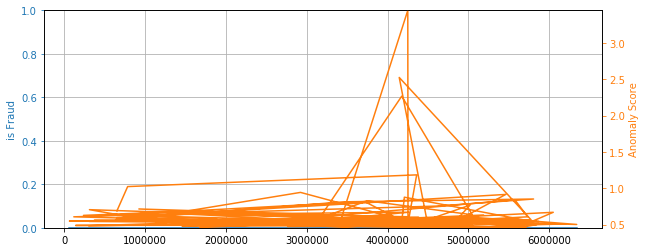

In [34]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the 
# anomaly found earlier in this notebook
#
#start, end = 0, len(dataTest)
start, end = 0, 100
dataTestTRANSFER_subset = dataTestTRANSFER[start:end]

ax1.plot(dataTestTRANSFER_subset['isFraud'], color='C0', alpha=0.8)
ax2.plot(dataTestTRANSFER_subset['score'], color='C1')

ax1.grid(which='major', axis='both')

ax1.set_ylabel('is Fraud', color='C0')
ax2.set_ylabel('Anomaly Score', color='C1')

ax1.tick_params('y', colors='C0')
ax2.tick_params('y', colors='C1')

ax1.set_ylim(0, 1)
ax2.set_ylim(min(dataTestTRANSFER_subset.score), max(dataTestTRANSFER_subset.score))
#ax1.set_xlim(0,len(dataTest))
fig.set_figwidth(10)

In [35]:
score_mean = dataTestTRANSFER['score'].mean()
score_std = dataTestTRANSFER['score'].std()
score_cutoff = score_mean + 20*score_std

anomalies = dataTestTRANSFER[dataTestTRANSFER['score'] > score_cutoff]
anomalies

,isFraud,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,score
4493789,0,13849394.93,0.00,0.0,2.885448e+08,3.023942e+08,7.336524
4181294,0,779571.94,0.00,0.0,2.724047e+08,2.731842e+08,7.200060
4137921,0,15581774.13,0.00,0.0,1.851411e+08,2.510078e+08,6.750823
4171359,0,27045408.93,196209.71,0.0,2.281226e+08,2.551680e+08,6.986701
3980217,0,48464778.69,0.00,0.0,2.629401e+08,3.114049e+08,7.351045
4146648,0,36115106.82,0.00,0.0,2.362896e+08,2.724047e+08,7.104427


In [ ]:
###
### CONCLUSION: pretty bad model, even training on just the TRANSFER subset.
###